# Impulsive BCR4BP problem

In [1]:
using DifferentialEquations
using Plots
using LinearAlgebra
import ForwardDiff
import DiffResults
using AstrodynamicsBase
import joptimise
using Printf

In [2]:
include("../../julia-r3bp/R3BP/src/R3BP.jl")
include("../src/SailorMoon.jl")   # relative path to main file of module

Main.SailorMoon

In [3]:
param3b = SailorMoon.dyanmics_parameters()
lps = SailorMoon.lagrange_points(param3b.mu2)

5×6 Matrix{Float64}:
  0.836915   0.0       0.0  0.0  0.0  0.0
  1.15568    0.0       0.0  0.0  0.0  0.0
 -1.00506    0.0       0.0  0.0  0.0  0.0
  0.487849   0.866025  0.0  0.0  0.0  0.0
  0.487849  -0.866025  0.0  0.0  0.0  0.0

In [4]:
lp = 2
Az_km = 1200.0
println("Halo guess Az_km: $Az_km")
northsouth = 3   # 1 or 3
guess0 = R3BP.halo_analytical_construct(param3b.mu2, lp, Az_km, param3b.lstar, northsouth)
res = R3BP.ssdc_periodic_xzplane([param3b.mu2,], guess0.x0, guess0.period, fix="period")
res.flag

Halo guess Az_km: 1200.0

1

In [5]:
res.x0

6-element Vector{Float64}:
  1.1226879860196828
  0.0
 -5.228885624166955e-26
  0.0
  0.1650993133797659
  0.0

In [6]:
x0_stm = vcat(res.x0, reshape(I(6), (6^2,)))[:]
prob_cr3bp_stm = ODEProblem(R3BP.rhs_cr3bp_svstm!, x0_stm, res.period, (param3b.mu2))
sol = solve(prob_cr3bp_stm, Tsit5(), reltol=1e-12, abstol=1e-12)#, saveat=LinRange(0, period, n+1))
monodromy = R3BP.get_stm(sol, 6)   # get monodromy matrix
ys0 = R3BP.get_eigenvector(monodromy, true, 1)
eps = 1e-6
if ys0[1] > 0
    svf = vcat(res.x0 + eps*ys0, 1.0)
else
    svf = vcat(res.x0 - eps*ys0, 1.0)
end

Linear stability ν = 618.7618470919092


7-element Vector{Float64}:
  1.1226882532375977
  2.793813746152613e-7
 -5.228883154550508e-26
 -7.710131455619898e-7
  0.16509880733691906
  1.339504158679477e-31
  1.0

In [7]:
# arrival LPO object
LPOArrival = SailorMoon.CR3BPLPO(
    res.x0, res.period, ys0, prob_cr3bp_stm, 1e-6, Tsit5(), 1e-12, 1e-12
);

### Construct optimization problem

In [8]:
rp_parking = (6378+200)/param3b.lstar   # parking orbit radius

0.01709689063726318

In [9]:
propagate_trajectory = function (x::AbstractVector{T}, get_sols::Bool=false) where T
    # unpack
    βf, tof, eta, r_apogee, ecc, raan, ϕ, m0, mf = x  # βf: Sun angle at final time
    tof_fwd = tof * eta
    tof_bck = tof * (1 - eta)
    
    # construct initial state
    sma = (rp_parking + r_apogee)/2
    sv0_kep = [sma, ecc, 0.0, raan, 0.0, 0.0]
    β0 = βf - param3b.oms*(tof_fwd + tof_bck)   # initial Sun angle
    sv0_i = AstrodynamicsBase.kep2cart(sv0_kep, param3b.mu1)
    sv0 = vcat(inertial2rotating(sv0_i, β0, 1.0) + [-param3b.mu2,0,0,0,0,0], m0)
    
    # construct final state
    #x0_stm = vcat(LPOArrival.x0, reshape(I(6), (36,)))
    #tspan = [0, ϕ*LPOArrival.period]
    #prob_cr3bp_stm = ODEProblem(R3BP.rhs_cr3bp_svstm!, x0_stm, tspan, [param3b.mu2,])
    #sol = solve(prob_cr3bp_stm, Tsit5(), reltol=1e-12, abstol=1e-12)
    svf = vcat(SailorMoon.set_terminal_state(ϕ, param3b, LPOArrival), mf)
    
    # forward propagation
    params = [param3b.mu2, param3b.mus, β0, param3b.as, param3b.oms, 0.0, 0.0, 0.0, 0.0, 0.0]
    tspan = [0, tof_fwd]
    prob_fwd = ODEProblem(R3BP.rhs_bcr4bp_thrust!, sv0, tspan, params)
    sol_fwd = solve(prob_fwd, Tsit5(), reltol=1e-12, abstol=1e-12);
    
    # back propagation
    params = [param3b.mu2, param3b.mus, βf, param3b.as, param3b.oms, 0.0, 0.0, 0.0, 0.0, 0.0]
    tspan = [0, -tof_bck]
    prob_bck = ODEProblem(R3BP.rhs_bcr4bp_thrust!, svf, tspan, params)
    sol_bck = solve(prob_bck, Tsit5(), reltol=1e-12, abstol=1e-12);
    
    # residual
    if get_sols == false
        return sol_bck.u[end][1:3] - sol_fwd[end][1:3]
    else
        return sol_fwd, sol_bck
    end
end

#1 (generic function with 2 methods)

In [10]:
# θf, tof, eta, r_apogee, ecc, raan, ϕ = x
xtest = [
    2.85, 21.7, 0.52, 3.9, 0.87, 4.5, 0.02, 1.5, 1.0
]
# θf, tof, eta, r_apogee, ecc, raan, ϕ
lx = [
    2.6, 18, 0.3, 4.0, 0.7, -4π, -1.0, 1.0, 1.0
]
ux = [
    3.2, 27, 0.7, 5.0, 0.995, 4π, 1.0, 10.0, 1.0
]

9-element Vector{Float64}:
  3.2
 27.0
  0.7
  5.0
  0.995
 12.566370614359172
  1.0
 10.0
  1.0

In [11]:
sol_fwd, sol_bck = propagate_trajectory(xtest, true);
propagate_trajectory(xtest, false)

3-element Vector{Float64}:
  0.3801893721129861
  0.04784120514124668
 -2.012666570528019e-25

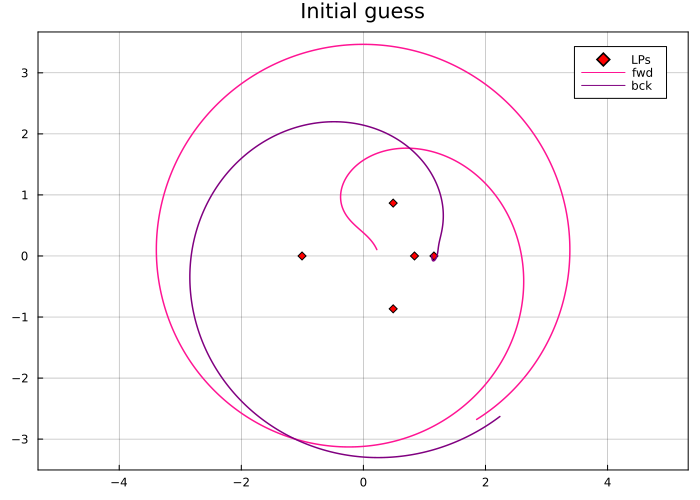

In [12]:
pcart = plot(size=(700,500), frame_style=:box, aspect_ratio=:equal, grid=0.4)
scatter!(pcart, lps[:,1], lps[:,2], marker=:diamond, color=:red, label="LPs")
# trajectory
plot!(pcart, Array(sol_fwd)[1,:], Array(sol_fwd)[2,:], color=:deeppink, linewidth=1.5, label="fwd")
plot!(pcart, Array(sol_bck)[1,:], Array(sol_bck)[2,:], color=:purple, linewidth=1.5, label="bck")
plot!(pcart; title="Initial guess")
pcart

In [13]:
# problem settings
ng = 3
lg = [0.0 for idx=1:ng];
ug = [0.0 for idx=1:ng];

fitness! = function (g, x)
    # evaluate objective & objective gradient (trivial)
    #f = 1       # whichever x corresponds to e.g. mass at LEO
    #g[:] = propagate_trajectory(x, false)
    
    sol_fwd, sol_bck = propagate_trajectory(x, true)
    g[:] = sol_bck.u[end][1:3] - sol_fwd.u[end][1:3]
    f = norm(sol_bck.u[end][4:6] - sol_fwd.u[end][4:6])
    return f
end

#7 (generic function with 1 method)

In [14]:
gfoo  = zeros(ng)
fitness!(gfoo, xtest)
gfoo

3-element Vector{Float64}:
  0.3801893721129861
  0.04784120514124668
 -2.012666570528019e-25

In [15]:
ip_options = Dict(
    "max_iter" => 200,   # approx 100
    "print_level" => 4,
    "acceptable_tol" => 1e-6,
    "constr_viol_tol" => 1e-6,
)
x0 = [el for el in xtest]
xopt, fopt, info = joptimise.minimize(
    fitness!, x0, ng;
    lx=lx, ux=ux, lg=lg, ug=ug,
    #derivatives=joptimise.ForwardAD(),
    options=ip_options,
);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Total number of variables............................:        8
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        8
                     variables with only upper bounds:        0
Total number of equality constraints.................:        3
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 86

     

In [16]:
info

:Solve_Succeeded

In [17]:
sol_fwd, sol_bck = propagate_trajectory(xopt, true);
propagate_trajectory(xopt, false)

3-element Vector{Float64}:
  1.2333325472013712e-9
 -5.056033369754687e-9
  1.8468160456803411e-34

In [18]:
dr = sol_bck.u[end][1:3] - sol_fwd.u[end][1:3]
norm(dr)

5.204285023714512e-9

In [19]:
dv = sol_bck.u[end][4:6] - sol_fwd.u[end][4:6]

3-element Vector{Float64}:
  2.3569214229191005e-6
 -9.329195715945815e-6
 -2.1263127803231448e-26

In [20]:
norm(dv)*param3b.lstar/param3b.tstar  # km/s

9.854050247174828e-6

In [21]:
for i = 1:length(xopt)
    @printf("% 3.3f | % 3.3f | % 3.3f\n", lx[i], xopt[i], ux[i])
end

 2.600 |  3.173 |  3.200
 18.000 |  24.864 |  27.000
 0.300 |  0.439 |  0.700
 4.000 |  4.830 |  5.000
 0.700 |  0.987 |  0.995
-12.566 |  10.783 |  12.566
-1.000 | -0.015 |  1.000
 1.000 |  8.221 |  10.000
 1.000 |  1.000 |  1.000


In [36]:
# θf, tof, eta, r_apogee, ecc, raan, ϕ = x
xopt

9-element Vector{Float64}:
  3.173389533428173
 24.864427772203808
  0.4388140337355883
  4.830490818447277
  0.987361631300983
 10.78282928285431
 -0.014877634867362618
  8.220995013586927
  1.0

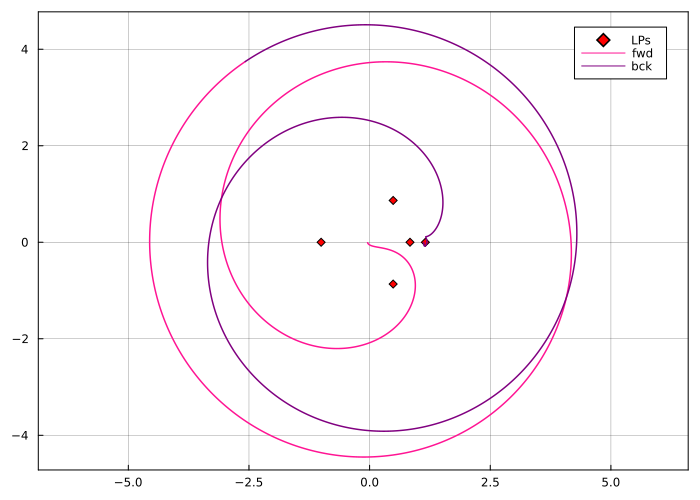

In [22]:
pcart = plot(size=(700,500), frame_style=:box, aspect_ratio=:equal, grid=0.4)
scatter!(pcart, lps[:,1], lps[:,2], marker=:diamond, color=:red, label="LPs")
# trajectory
plot!(Array(sol_fwd)[1,:], Array(sol_fwd)[2,:], color=:deeppink, linewidth=1.5, label="fwd")
plot!(Array(sol_bck)[1,:], Array(sol_bck)[2,:], color=:purple, linewidth=1.5, label="bck")

pcart

In [23]:
# unpack optimal solution
βf, tof, eta, sma, ecc, raan, ϕ = xopt
tof_fwd = tof * eta
tof_bck = tof * (1 - eta)
β0 = βf - param3b.oms*tof                # initial Sun angle

26.177958093452133

In [24]:
xopt

9-element Vector{Float64}:
  3.173389533428173
 24.864427772203808
  0.4388140337355883
  4.830490818447277
  0.987361631300983
 10.78282928285431
 -0.014877634867362618
  8.220995013586927
  1.0

## Plot in Sun-Earth rotating frame

In [25]:
SE_system = R3BP.get_cr3bp_param(10,399)
EM_system = R3BP.get_cr3bp_param(399,301)

scale_l = EM_system.lstar/SE_system.lstar
scale_v = (EM_system.lstar/EM_system.tstar) / (SE_system.lstar/SE_system.tstar)
scale_t = EM_system.tstar/SE_system.tstar

0.07469828599591845

In [26]:
function planetmoon2sunplanet(
    state::Vector, μ_moon::Real, μ_sun::Real, theta::Real, om::Real,
    scale_l::Real, scale_v::Real, scale_t::Real, final_shift::Bool=false
)
    # 1. shift to Planet-centered, planet-moon rotating frame
    state_1 = state + [μ_moon, 0, 0, 0, 0, 0]
    # 2. convert to PLanet-centered, inertial
    state_2 = rotating2inertial(state_1, theta, om)
    # 3. re-scale
    state_3 = vcat(
        state_2[1:3] * scale_l,
        state_2[4:6] * scale_v
    )
    # 4. convert to Planet-centered, Sun-planet rotating frame
    theta_sp = scale_t * theta
    state_4 = inertial2rotating(state_3, theta_sp, om)
    # 5. shift to Sun-planet barycenter centered, Sun-planet rotating frame
    if final_shift == true
        return state_4 + [1 - μ_sun, 0, 0, 0, 0, 0]
    else
        return state_4
    end
end


planetmoon2sunplanet (generic function with 2 methods)

In [27]:
sol_bck_se = zeros(7,length(sol_bck.u))
for (idx,sv) in enumerate(sol_bck.u)
    theta = βf + param3b.oml*sol_bck.t[idx]
    sol_bck_se[1:6,idx] = planetmoon2sunplanet(
        sv[1:6], param3b.mu2, param3b.mus, theta, 1.0, #param3b.oms,
        scale_l, scale_v, scale_t
    )
    sol_bck_se[7,idx] = sv[7]
end

sol_fwd_se = zeros(7,length(sol_fwd.u))
for (idx,sv) in enumerate(sol_fwd.u)
    #theta = β0 + sol_fwd.t[idx]
    theta = βf + param3b.oml*sol_bck.t[end] - param3b.oml*(tof_fwd - sol_fwd.t[idx])
    sol_fwd_se[1:6,idx] = planetmoon2sunplanet(
        sv[1:6], param3b.mu2, param3b.mus, theta, 1.0, #param3b.oms,
        scale_l, scale_v, scale_t
    )
    sol_fwd_se[7,idx] = sv[7]
end

In [28]:
βf, β0

(3.173389533428173, 26.177958093452133)

In [29]:
βf - param3b.oms*tof

26.177958093452133

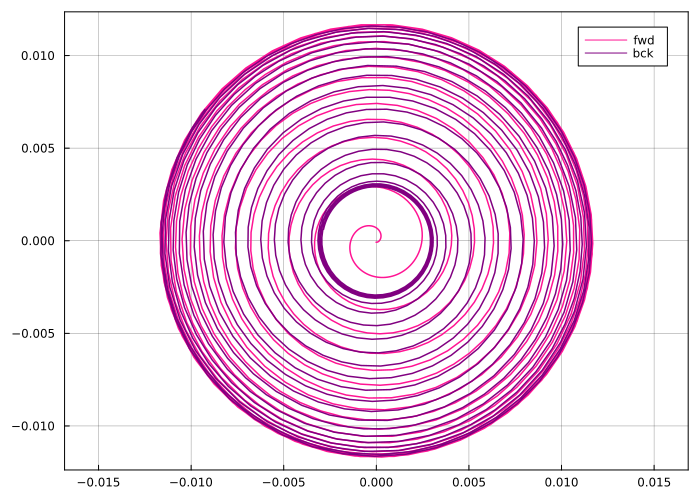

In [30]:
pcart = plot(size=(700,500), frame_style=:box, aspect_ratio=:equal, grid=0.4)

# trajectory
#plot!(Array(sol_fwd)[1,:], Array(sol_fwd)[2,:], color=:deeppink, linewidth=1.5, label="fwd")
plot!(sol_fwd_se[1,:], sol_fwd_se[2,:], color=:deeppink, linewidth=1.5, label="fwd")
plot!(sol_bck_se[1,:], sol_bck_se[2,:], color=:purple, linewidth=1.5, label="bck")

pcart

## Plot in inertial frame

In [31]:
sol_fwd.t[end] - sol_bck.t[end]

24.864427772203804

In [32]:
sol_fwd_i = zeros(7,length(sol_fwd.u))
for (idx,sv) in enumerate(sol_fwd.u)
    theta = βf - tof + sol_fwd.t[idx]
    sol_fwd_i[1:6,idx] = rotating2inertial(sv[1:6], theta, 1.0)
    sol_fwd_i[7,idx] = sv[7]
end

sol_bck_i = zeros(7,length(sol_bck.u))
for (idx,sv) in enumerate(sol_bck.u)
    theta = βf + sol_bck.t[idx]
    sol_bck_i[1:6,idx] = rotating2inertial(sv[1:6], theta, 1.0)
    sol_bck_i[7,idx] = sv[7]
end

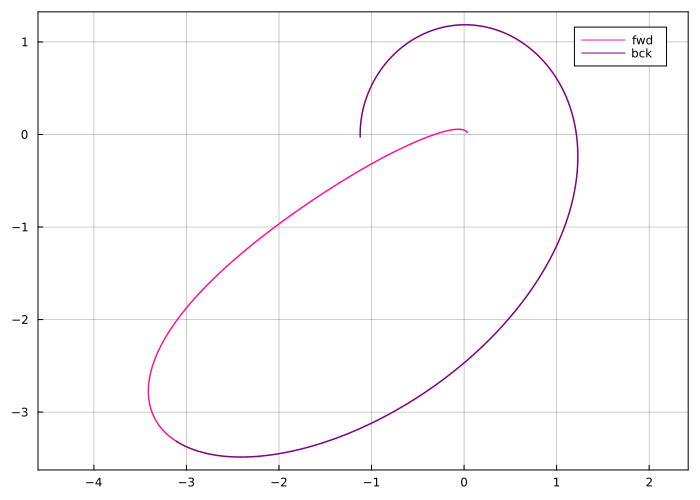

In [33]:
pcart = plot(size=(700,500), frame_style=:box, aspect_ratio=:equal, grid=0.4)

# trajectory
plot!(sol_fwd_i[1,:], sol_fwd_i[2,:], color=:deeppink, linewidth=1.5, label="fwd")
plot!(sol_bck_i[1,:], sol_bck_i[2,:], color=:purple, linewidth=1.5, label="bck")

pcart

In [34]:
1737/param3b.lstar

0.00451463956170966

In [35]:
0.001*param3b.lstar

384.74832292972934